In [1]:
import torch
import torch.utils.data
from skimage.io import imread
from scipy.ndimage import gaussian_filter
import cv2
import json
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.utils import make_grid
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import h5py

# Use *torchvision* helpers to load the dataset

In [15]:
images = ImageFolder('E:/temp/hand_labels_synth/hand_labels_synth')
# for this to work, one needs to delete 'output_viz_synth' because it includes images that ruin the alignment
joints = DatasetFolder('E:/temp/hand_labels_synth/hand_labels_synth',
                       loader=lambda x: np.asarray(json.load(open(x, 'r'))['hand_pts']), extensions='json')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, augmentation=100):
        super(Dataset, self).__init__()
        self.augmentation = augmentation
        
    def __len__(self):
        return len(images) * self.augmentation
    
    def __getitem__(self, idx_):
        idx = idx_ // self.augmentation
        aug = idx_ % self.augmentation
        
        # backup random state and make random reproducible
        state = np.random.get_state()
        np.random.seed(idx_)
        
        # fetch from the loadeds
        img, _ = images[idx]
        J, _ = joints[idx]
        img = np.array(img).astype(np.float32) / 255.
        
        # keep valid joints (not all images have all joints)
        j = J[J[...,-1] == 1.0,:2]
        
        # get bounds
        upper_left = j.min(axis=0)
        bottom_right = j.max(axis=0)
        
        # compute center and scale
        center = 0.5 * upper_left + 0.5 * bottom_right
        scale = np.linalg.norm(upper_left - bottom_right) * 0.5
        
        # recompute bounds for an inscribing circle
        upper_left = center - scale
        bottom_right = center + scale
                
        # generate the initial perspective transform (to further purturb for augmentation)
        transform = np.eye(3)
        transform[:2,2] = upper_left
        transform[0, 0] = transform[1, 1] = 2 * scale / 64
        
        def apply_transform(transform):
            nz = J[...,-1] != 0.0
            JJ = (np.linalg.inv(transform) @ J.T).T
            JJ[nz] /= JJ[nz,-1][...,np.newaxis]
            JJ[JJ[:,0] < 0] = 0
            JJ[JJ[:,0] >= 64] = 0
            JJ[JJ[:,1] < 0] = 0
            JJ[JJ[:,1] >= 64] = 0
            return cv2.warpPerspective(img, np.linalg.inv(transform), (64, 64), borderValue=np.nan), JJ
                    
        def check_transform(img, J):
            return not np.any(np.isnan(img)) and (J[...,-1] != 0).sum() > 5

        # pivot transform
        pivot = np.eye(3)
        pivot[:2,2] = -32
        ipivot = np.linalg.inv(pivot)

        # tries transform on local transform variable
        def try_transform(base_transform, T):
            for effort in range(10):
                t = ipivot @ T() @ pivot
                if check_transform(*apply_transform(base_transform @ t)):
                    return base_transform @ t;
            return base_transform
            
        # sample rotation around center
        def generate_rotation():
            theta = np.random.rand() * np.pi
            c, s = np.cos(theta), np.sin(theta)
            return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
                        
        # sample scale around center (32, 32)
        def generate_scaling():
            scale = np.maximum(1e-2, np.random.randn() + 1)
            return np.array([[scale, 0, 0], [0, scale, 0], [0, 0, 1]])
        
        # sample perspective distortion
        def generate_perspective():
            shear_x = np.random.randn() * 0.2
            shear_y = np.random.randn() * 0.2
            SX = np.eye(3)
            SX[1,0] = shear_x
            SY = np.eye(3)
            SY[0,1] = shear_y
            return SX @ SY
        
        for rnd_trans in [generate_rotation, generate_scaling, generate_perspective]:
            transform = try_transform(transform, rnd_trans)
        
        # generate transformed image and joints
        img, J = apply_transform(transform)
        
        # sample gamma (per channel) correction
        gamma = np.maximum(0.5, np.random.randn(3))
        img = (img ** gamma).mean(axis=-1)
        
        # sample blur
        sigma = 2*np.maximum(0, np.random.rand())
        img = gaussian_filter(img, sigma)
        
        # sample noise
        img = img + np.random.randn() * 0.001 * np.random.randn(*img.shape)
        
        # clip image
        img = np.maximum(0, np.minimum(1, img))
        
        # restore random state
        np.random.set_state(state)
        
        # return
        return img, J

# Create a dataset instance and a batched data loader

In [16]:
ds = Dataset()
dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

# Visualize some results

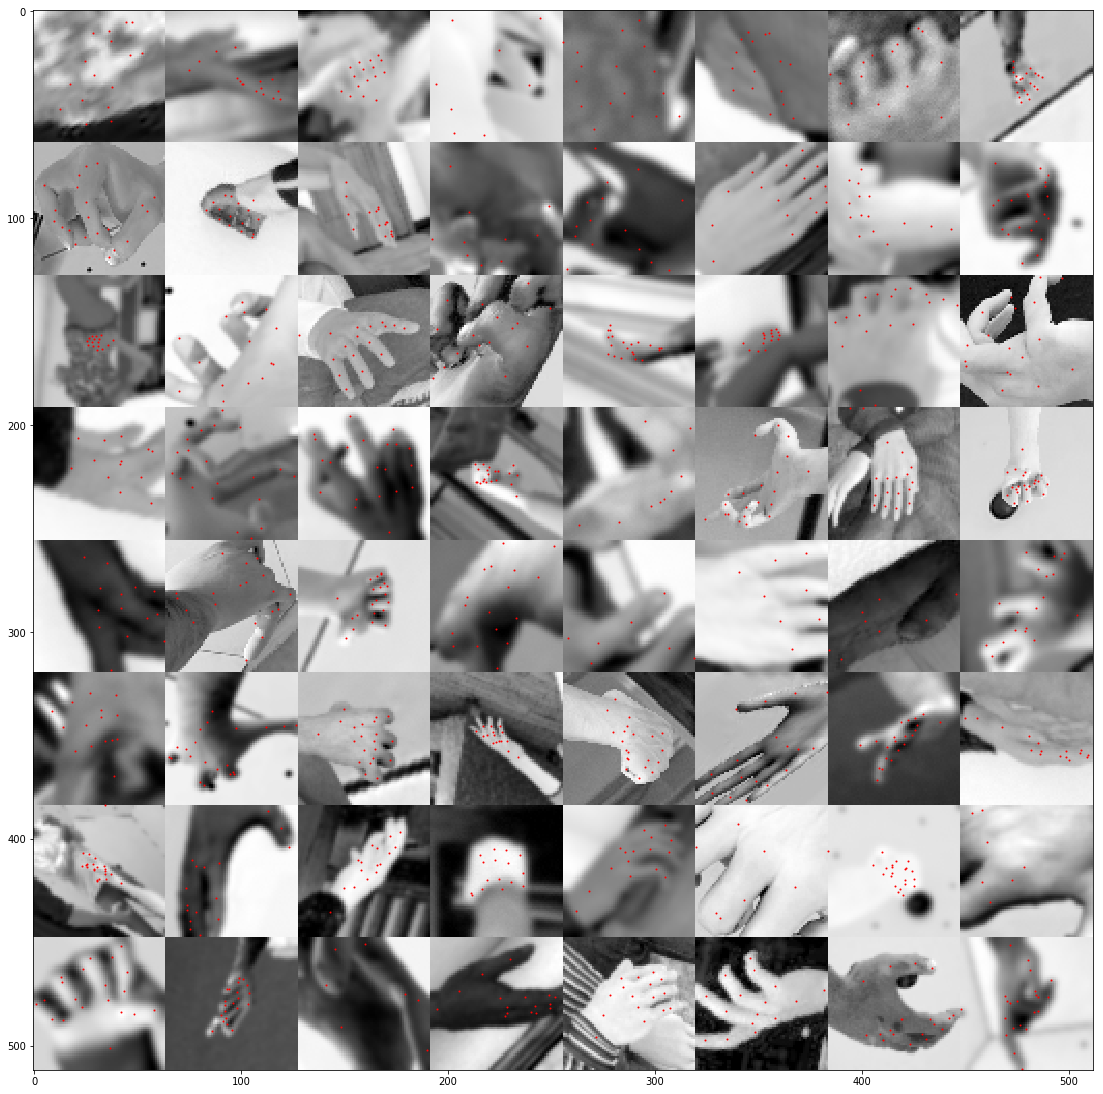

In [32]:
X, Y = iter(dl).next()
plt.figure(figsize=(15,15))
plt.imshow(make_grid(X[:,None,:,:], padding=0, normalize=True, scale_each=True).permute(1, 2, 0))
for i, J in enumerate(Y):
    J = J[J[...,-1]!=0]
    offset_x = (i % 8) * 64
    offset_y = (i // 8) * 64
    
    plt.scatter(J[...,0] + offset_x,
                J[...,1] + offset_y,
                c = 'red', s=1)
plt.tight_layout(pad=0)